# Notebook Explanation
Translated from written lab notebook. Begun on 21.Nov.19

This is an explanitory log of Nick Baker's second attempt at case studies 3 & 4 of the IEA competition. The first attempt was done in Julia, and is incomplete. Only recoding of the target function was completed, no optimization. This attempt will be completed in Python, using PyOptSparse, and Jared Thomas's [WEC method](http://scholarsarchive.byu.edu/cgi/viewcontent.cgi?article=2988&context=facpub) decribed in a paper linked on the subject.

# Preparatory work
Brainstorming with coworkers to figure out how to attack the problem.

## Possible Courses of Action (COAs) to Approach the Problem

In a conversation had with [PJ Stanley and Jared Thomas](http://flow.byu.edu/people/#phd-students) between 4-16.June.19, a few different methods to optimize this problem were discussed.

The two (2) main to obstacles making cs3&4 different than a normal gradient-based optimization is:
1. Non-concave boundary
2. Non-continous design space
Both issues will give gradient-based solvers difficulty.

For approaches to both, see subsections immediately following below.

### 1. Non-concave Boundary Issue (cs3&4)

The boundary (included below) for cs3 is included here.
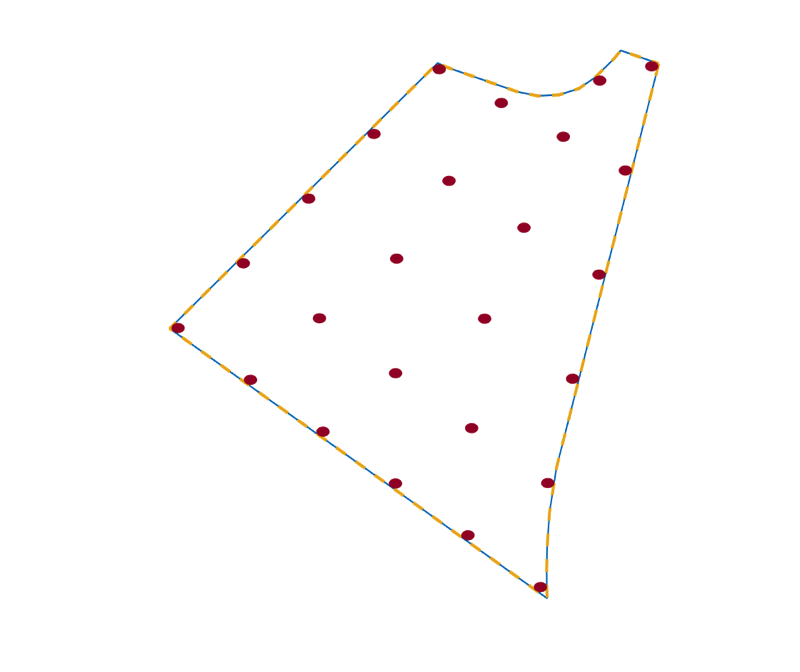
<img src="../figures/cs3turbines.png" alt="cs3 boundary with example turbine placement" width="500"/>
One can easily see that the upper portion, as well as the lower right corner of the area, have concavities that would make any algorithm traversing of the boundary unexpectedly change the sign of its derivative (a common method), confusing the algorithm.

Usually optimizers are given simple constraint equations that are binary. (i.e. for a box boundary: if it's above the line, left of the right line, below the top line, and right of the left line, it's a valid location (or really any *n-sized* convex boundary)). However non-concave boundaries aren't able to follow this, since the peninsula-like portion doesn't lie to the interior of certain segments of the boundary.

The methods PJ, Jared, and I discussed to obviate this difficulty are listed below, from least complex to most complex:
1. Split boundary into vertical segments, with divisions at inflection points.
    - This will greatly increase the number of constraints, and hence function calls. algorithmically simple, but computationally expensive.
    <img src="figures/notebook-scans/vertical-partitions.jpg" alt="vertical partition visualization" width="250"/>
2. Grid method. Only allow turbines to be placed on certain pre-determined grid coordinates.
    - This makes the boundary irrelivant, since the optimizer only chooses between a discrete number of location selections
    - Is computationally simpler, but looses much of the benefits offered by gradient-based optimizers.
3. Transformation/mapping of non-uniform boundary to a cartesian coordinate system.
    - This would translate to a generic cartesian coordinate system for very normal and simple computations.
    - The problem is coming up with a generalized way to map a cartesian coordinate system to ANY non-uniform boundary.
    - To save time, this can be done by hand since our boundaries are known. __However I think much work can be done here, even another paper's worth of developing a method for a universal algorithm that will map a cartesian grid to a non-uniform boundary.__
    - This seems the least computationally expensive, but most complex in terms of algorithm development.
    <img src="figures/notebook-scans/map0.jpg" alt="map0" width="300"/>
    <img src="figures/notebook-scans/map1.png" alt="map1" width="300"/>
    <img src="figures/notebook-scans/map2.png" alt="map2" width="300"/>
---------
I would really like to develop method (3), but I think for time I'll have to go with (1), just to get a result.

### 2. Non-continous Boundary Issue (cs4 only)

That the boundary has discrete sections proves difficult for a gradient-based optimizer, since it needs continuous gradients (no discontinuities) to function.
    <img src="figures/cs4Turbines-big.png" alt="cs4 placed turbines" width="500"/>

To get around the inability of gradient-based optimization to deal with discontinuous areas, we came up with some solutions:
1. Preapportion a set number of turbines per area, as done for the example layout I relased with the startup files.
    - Permits no movement of turbines to adjacent sections.
    - Simple to code and compute, though not generically not the "best" method.
2. Optimize each segment individually, and take any losses due to neighboring turbines in neighboring segments as negligible
    - Even simpler to compute. trade-off in AEP optimization for adjacent turbines would be made up for in computing time, since each portion could be done in parallel.
3. Treat the entire area as allowable placement, then through a series of optimizations make higher and higher penalties for placement in no-go lanes until all turbines are clear of shipping lanes.
    - Most complicated to code, since it requires a few rounds if iteration and optimization
    - Probably the most "correct" in terms of using the full power of the gradient based optimizer.
    <img src="figures/notebook-scans/relaxing-boundary.jpg" alt="relaxing shipping lane boundary" width="150"/>
4. Grid-based system, where boundaries don't matter, but turbines can be placed only in pre-determined locations.
    - Simplest to code, probably low-cost computationally.
    - Loses the benefit of gradient-based optimization.

### Further work

This section is a list on ideas to develop/publish on that I think are beyond the scope of the IEA participation

1. I think work could be done on developing a generic mapping/transformation algorithm
    - There is much litarature on mapping a cartesian to a non-uniform, but nothing on how to map it BACK to cartesian for a given location in a non-uniform area)
    - The locations are mapped in the non-uniform world, but the wakes are calculated in the cartesian world. So it gradients calculated in one system with function calls made in another.
    - When things get to the edges of the mapping, the gradients will not be proportionate to the perterbations, so some scaling needs to be done to incentivise movement at the squished edges. This will take some thought and consideration though, for which I don't currently have time.
2. The penalty method mentioned for cs4, number (3).
    - Much like Jared's WEC method, but for permissible plaement, not wake penalty.
    - This would require a fair bit of work to accomplish.
3. SOWFA visualization of the participant submissions.
    - NREL's SOWFA was installed on the supercomputer by Jared Thomas.
    - Its higher-fidelity modelling would make for great 3D visualizaitons of the wind farms.

## Selected COA

`1709.21.Nov.19:` Though it was months ago, in a lab meeting Dr. Ning advised to take the simplest approach (vertical partitioning), but I just got back from a long walk to the Wilk and back, and I really feel like the mapping can work, with a modification. The difficulty was the reverse mapping.
        <img src="figures/notebook-scans/map2.png" alt="map2" width="300"/>

Though I can go in the direction that follows the arrow, if given a random turbine location in the spherical system, I have no knowledge/method for easily computing the mapped location to the grid again (going against the arrow).

This would only be a problem if I did the optimization entirely in the translated space. The way I will do it (though it will introduce a new mapping function, and effectively double the number of function calls), is to have the optimizer do all work in the square cartesian space, but when calculating wake effects, do THAT function calculation in the translated space. This mean every time the target function is called, a coordinate translation function will also need to be called first.

Though the 'right' way to do this would be to write the generic algorithm that could map any non-square boundary to a square system, for the purposes of time and simplicity, I will do the mapping myself, and hard-code that translation. The good thing is I think this work is mostly already done from when I compelted the initial turbine layout.

This is train of thought was only for attacking the problem of cs3. For cs4, I'll use the same strategy, but have to preassign the mapping per each section. The mappings won't be continous, but the wakes will effect each other (option (1), not option (2) from the "Non-continous boundary issue" section above).

### Possible problem

Though human-selecting turbine apportionment is the simplest, it's not very generic/globally applicable. It SHOULD give a relatively good answer, but there could be a hypothetical scenario where pushing a single turbine into another section might give a better result. This could be because the human apportonment was originally incorrect, or shifting of the turbines might make an oddly beneficial situation if one turbin'es wake is moved (two are put closer together so another could be free or something).

An optimizer would figure this out through trial and error, and robbing it of this generality could shackle it's hands. But I don't have the time to ponder and solve how to do this thing.

### Point to be made

Very important: I think smart _initial_ turbine placement is key. Either:
  1. Recursively placing turbines in the most eqidistant manner possible (not in a grid, but one at a time at the point that is furthest from any other turbine but within the boundary)
  2. As well as doing a gradient-free initial placement, then a gradient-based optimization to fine-tune. In otherwords a two-step algorithm.

### Mapping explanation
`1755.21.Nov.19`

I just had a long conversation with [Eduardo](https://www.linkedin.com/in/alvarezedo/) in the FLOWlab. He did a very similar problem earlier this year when working with PJ. The work he did is stored as part of his FLOWlab repository called [wind-farm-utilities](https://github.com/byuflowlab/wind-farm-utilities), and is specifically summarized in the sub-directory's [Jupyter notebook](https://github.com/byuflowlab/wind-farm-utilities/blob/master/docs/geometry_processing.ipynb) (scroll down the the "Fluid Domain" subheading, about 80% down towards the bottom of the page for the mapping portion.

He too came to the same conclusion I did above that there exists an algorithm by which __any__ irregular boundary could be mapped, but that it will be much simpler/time efficient to do the vertex selection by hand and automate the interpolation of the grid system.

He _stressed_ , however, to visualize the mapping while coding in order to ensure all irregular corners are countoured. Though his boundary was continuous (a circle), and mine is non-continuous (with various line segments), his solution will be applicable. The algorithm was to:
1. Partition the irregular edges at regular intervals using the arc length.
 - I already wrote this function when putting the initial turbine locations.
2. Once those points are known, _spline_ the points, to get a continuous function for that boundary portion.
3. Create the oddly-shaped contoured grid-lines.
 - As a point follows the line, weight it's location.
 - Strongest at the ends, weighted to the endpoint locations
 - Then along the line, weight to the created spline

# Case Study 3 workout
Continued in a new notebook numbered '02'